In [213]:
import os
os.chdir('..')
os.chdir('..')
import sys
sys.path.append('/home/Sajana/visualizations/vis/src/')
sys.path.append('/home/hanlin/231NProject/')
sys.path

['/home/hanlin/231NProject',
 '/opt/anaconda3/lib/python37.zip',
 '/opt/anaconda3/lib/python3.7',
 '/opt/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/opt/anaconda3/lib/python3.7/site-packages',
 '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/hanlin/.ipython',
 '/home/Sajana/visualizations/vis/src/',
 '/home/hanlin/231NProject/',
 '/home/Sajana/visualizations/vis/src/',
 '/home/hanlin/231NProject/',
 '/home/Sajana/visualizations/vis/src/',
 '/home/hanlin/231NProject/']

In [214]:
from guided_backprop import GuidedBackprop
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
import torch
import os
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import sys


import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score

from torch.utils.data import Dataset
from PIL import Image
from models.chexnet.DensenetModels import DenseNet121
from models.models import ResNet18
from tensorboardX import SummaryWriter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
"""
Read images and corresponding labels.
"""
class ChestXrayDataSet(Dataset):
    
    def convert_to_ones(self, df, disease):
        df[disease] = df[disease].replace([-1.0], 1.0)
    
    def convert_to_zeros(self, df, disease):
        df[disease] = df[disease].replace([-1.0], 0.0)
        
    def convert_to_multi(self, df, disease):
        df[disease] = df[disease].replace([-1.0], 2.0)

    def __init__(self, data_dir, image_list_file, diseases=['Atelectasis', 'Consolidation', 'Edema','Cardiomegaly', 'Pleural Effusion'], side='Frontal', transform=None):
        """
        Args:
            data_dir: path to image directory.
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
        """
        image_names = []
        labels = []
        chex_df = pd.read_csv(image_list_file)
        chex_df = chex_df.fillna(0.0)
        chex_df = chex_df.loc[chex_df['Frontal/Lateral'] == side]
        self.convert_to_ones(chex_df, 'Atelectasis')
        self.convert_to_ones(chex_df, 'Consolidation')
        self.convert_to_ones(chex_df, 'Edema')
        self.convert_to_multi(chex_df, 'Cardiomegaly')
        self.convert_to_multi(chex_df, 'Pleural Effusion')

        labels = chex_df.as_matrix(columns=diseases)
        labels = list(labels)

        image_names = chex_df.as_matrix(columns=['Path']).flatten()
        image_names = [os.path.join(data_dir, im_name) for im_name in image_names]

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        print(image_name)
        image = Image.open(image_name).convert('RGB')
        label = torch.FloatTensor(self.labels[index])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_names)

In [217]:
from misc_functions import (
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)

In [218]:
def occlude(image,x,y):
    occ = torch.zeros(image.shape[1],30,30)
    image[:,:,x:x+30,y:y+30] = occ
    return image

In [219]:
class ChexnetTrainer(): 
    def generate_gradients(input_index, target_class,loss,dataLoader,GBP):
        GBP.model.eval()        
        for batchID, (input, target) in enumerate (dataLoader):
            if batchID != input_index:
                continue;
                
            # Zero gradients
            GBP.model.zero_grad()
            target = target.cuda()
            varInput = torch.autograd.Variable(input, requires_grad=True)
            varTarget = torch.autograd.Variable(target)
            print(target)
            varOutput = GBP.model(varInput)


            varOutput[:,0] = torch.sigmoid(varOutput[:,0])
            varOutput[:,1] = torch.sigmoid(varOutput[:,1])
            varOutput[:,2] = torch.sigmoid(varOutput[:,2])

            lossvalue = loss(varOutput,varTarget,target_class)

            lossvalue.backward()
#             varInput = occlude(varInput,0,0)
            gradients_as_arr = varInput.grad.abs().max(dim=1)[0].squeeze().cpu().numpy()
            return gradients_as_arr, varInput.squeeze().detach().cpu().numpy()
    
    def occlude_grads(input_index, target_class,loss,dataLoader,model):
        model.eval()        
        with torch.no_grad():
            for batchID, (input, target) in enumerate (dataLoader):
                if batchID != input_index:
                    continue;

                # Zero gradients
                model.zero_grad()
                target = target.cuda()
                varInput = torch.autograd.Variable(input, requires_grad=True)
                varTarget = torch.autograd.Variable(target)

                for i in range(90,210,30):
                    for j in range(0,300,30):
                        model.zero_grad()
                        varInputi = occlude(varInput.clone(),i,j)    
                        varOutput = model(varInputi)


                        varOutput[:,0] = torch.sigmoid(varOutput[:,0])
                        varOutput[:,1] = torch.sigmoid(varOutput[:,1])
                        varOutput[:,2] = torch.sigmoid(varOutput[:,2])


                        ### VAL Preds for AUROC
                        bPRED = torch.zeros(varOutput.shape[0], 5).cuda()
                        bPRED[:,0] = varOutput[:,0]
                        bPRED[:,1] = varOutput[:,1]
                        bPRED[:,2] = varOutput[:,2]

                        softmax = torch.nn.Softmax()
                        soft_a = softmax(varOutput[:,3:6]).data
                        a0, a1, a2 = soft_a[:, 0], soft_a[:, 1], soft_a[:, 2]
                        bPRED[:, 3] = a1/(a0+a1)
                        soft_b = softmax(varOutput[:,6:9]).data
                        b0, b1, b2 = soft_b[:, 0], soft_b[:, 1], soft_b[:, 2]
                        bPRED[:, 4] = b1/(b0+b1)
                        print(varTarget)
                        print(bPRED)
                        varInputi = varInputi.squeeze().detach().cpu().numpy()
                        plt.imshow(varInputi[0,:,:])
                        plt.show()
                        del softmax
                        del soft_a
                        del a0
                        del a1
                        del a2
                        del b1
                        del b2
                        del b0
                        del bPRED
                        del varOutput
                        del varInputi
    
    def visualize(input_index, target_index,pathDirData, pathFileTrain, pathFileVal, nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, transResize, transCrop,classes):
        
        def lossCriterion(varOutput,varTarget,spec_class):
            CEloss =  torch.nn.CrossEntropyLoss()
            BCEloss = torch.nn.BCELoss()

            L1 = BCEloss(varOutput[:,0],varTarget[:,0]) 
            L2 = BCEloss(varOutput[:,1],varTarget[:,1])
            L3 = BCEloss(varOutput[:,2],varTarget[:,2])
            varTarget = varTarget.long()
            L4 = CEloss(varOutput[:,3:6],varTarget[:,3])
            L5 = CEloss(varOutput[:,6:9],varTarget[:,4])

            loss = torch.zeros(5)
            loss[0] = L1
            loss[1] = L2
            loss[2] = L3
            loss[3] = L4
            loss[4] = L5
            return loss[spec_class-1]
        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE
        if nnArchitecture == 'DENSE-NET-121': model = DenseNet121(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'DENSE-NET-169': model = DenseNet169(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'DENSE-NET-201': model = DenseNet201(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'RES-NET-18': model = ResNet18(nnClassCount, nnIsTrained).cuda()
        
        model = torch.nn.DataParallel(model).cuda()
        modelCheckpoint = torch.load('/home/hanlin/231NProject/best_models/forward121/m-37050_0-Copy1.897.pth.tar')
        model.load_state_dict(modelCheckpoint['state_dict'])
        
        
        #-------------------- SETTINGS: DATA TRANSFORMS |TRAIN|
        normalize = transforms.Normalize([0.50616586, 0.50616586, 0.50616586], [0.2879059, 0.2879059, 0.2879059]) #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        transformList = []
        transformList.append(transforms.Resize(transResize))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)    
        transformSequence=transforms.Compose(transformList)

        #-------------------- SETTINGS: DATASET BUILDER |TRAIN|
                    
        datasetTrain = ChestXrayDataSet(data_dir=pathDirData,image_list_file=pathFileTrain, transform=transformSequence)              
        dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=4, pin_memory=True)
        
        #-------------------- SETTINGS: DATASET BUILDERS |VAL|
        datasetVal =   ChestXrayDataSet(data_dir=pathDirData, image_list_file=pathFileVal, transform=transformSequence)
        dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=trBatchSize, shuffle=False, num_workers=4, pin_memory=True)
        
        
        #-------------------- SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

        #-------------------- SETTINGS: LOSS
        loss = lossCriterion
        
        
        
        
        #---------- Visualize code
#         GBP = GuidedBackprop(model)
        


        # Guided backprop
        
        # Get gradients
#         GBP.generate_gradients = ChexnetTrainer.generate_gradients

        ChexnetTrainer.occlude_grads(input_index, target_index,lossCriterion,dataLoaderVal,model)
    

        return 
        guided_grads, x = ChexnetTrainer.generate_gradients(input_index, target_index,lossCriterion,dataLoaderVal,GBP)

        
        print('Reg')
        plt.imshow(guided_grads)
        plt.show()
        plt.imshow(x[0,:,:])
        plt.show()

        
        
        # Save colored gradients
#         save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
#         # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        print(grayscale_guided_grads.shape)
#         plt.imshow(grayscale_guided_grads)
#         plt.show()

#         # Save grayscale gradients
#         save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')

#         # Positive and negative saliency maps
        pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        print('Pos')
        plt.imshow(pos_sal)
        plt.show()
#         print('Neg')
#         plt.imshow(neg_sal)
#         plt.show()



#         save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
#         save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
        print('Guided backprop completed')
        

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0779, 0.0338, 0.0401, 0.0037, 0.0106]], device='cuda:0')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


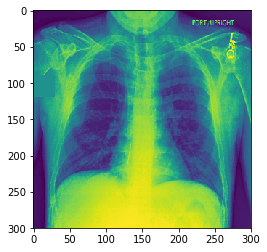

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0817, 0.0350, 0.0409, 0.0035, 0.0104]], device='cuda:0')


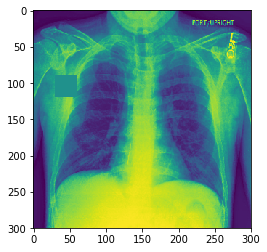

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0832, 0.0358, 0.0456, 0.0038, 0.0109]], device='cuda:0')


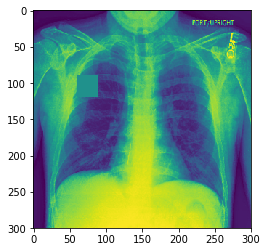

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0803, 0.0350, 0.0462, 0.0038, 0.0108]], device='cuda:0')


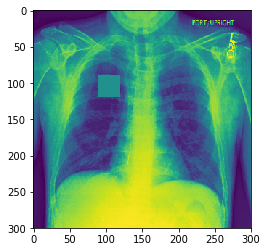

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0799, 0.0341, 0.0485, 0.0040, 0.0108]], device='cuda:0')


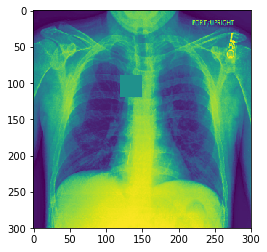

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0838, 0.0352, 0.0443, 0.0041, 0.0110]], device='cuda:0')


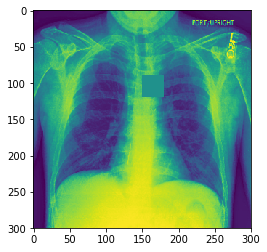

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0812, 0.0353, 0.0399, 0.0045, 0.0118]], device='cuda:0')


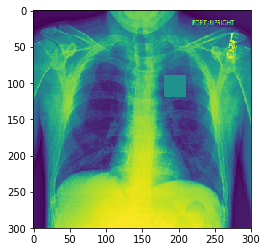

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0736, 0.0306, 0.0388, 0.0039, 0.0102]], device='cuda:0')


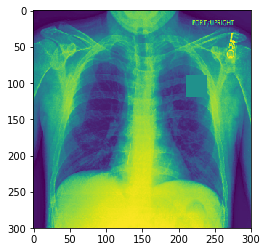

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0788, 0.0330, 0.0449, 0.0037, 0.0105]], device='cuda:0')


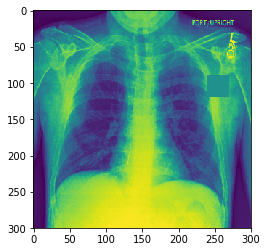

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0785, 0.0324, 0.0423, 0.0035, 0.0107]], device='cuda:0')


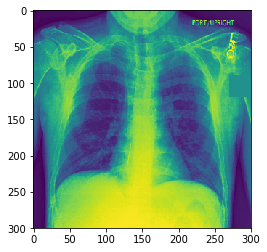

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0752, 0.0334, 0.0457, 0.0036, 0.0110]], device='cuda:0')


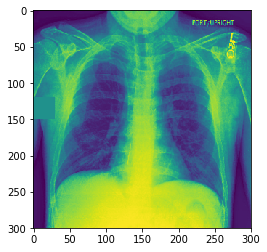

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0733, 0.0297, 0.0388, 0.0034, 0.0110]], device='cuda:0')


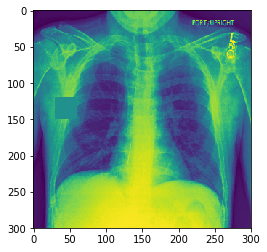

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0770, 0.0342, 0.0371, 0.0038, 0.0104]], device='cuda:0')


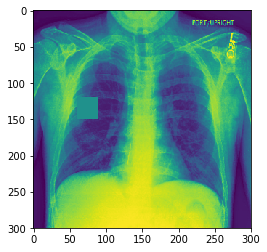

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0694, 0.0305, 0.0343, 0.0041, 0.0101]], device='cuda:0')


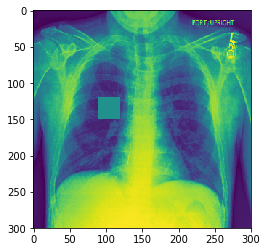

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0822, 0.0366, 0.0437, 0.0051, 0.0123]], device='cuda:0')


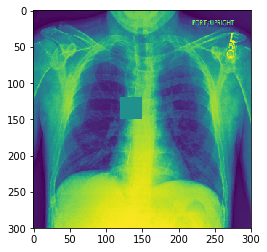

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0892, 0.0372, 0.0362, 0.0054, 0.0130]], device='cuda:0')


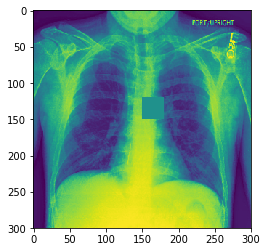

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0788, 0.0312, 0.0330, 0.0050, 0.0117]], device='cuda:0')


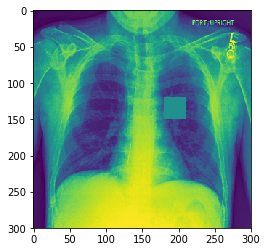

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0800, 0.0317, 0.0416, 0.0042, 0.0116]], device='cuda:0')


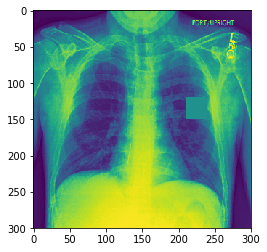

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0779, 0.0319, 0.0483, 0.0038, 0.0107]], device='cuda:0')


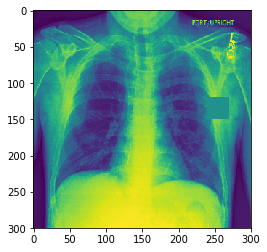

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0799, 0.0341, 0.0457, 0.0037, 0.0112]], device='cuda:0')


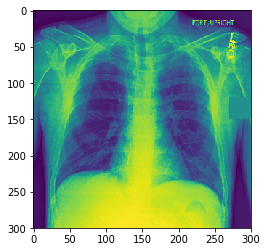

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0776, 0.0338, 0.0458, 0.0039, 0.0114]], device='cuda:0')


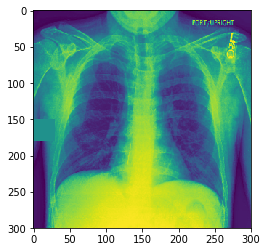

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0784, 0.0306, 0.0352, 0.0038, 0.0109]], device='cuda:0')


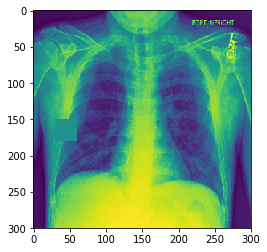

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0972, 0.0309, 0.0236, 0.0048, 0.0105]], device='cuda:0')


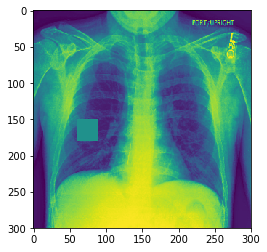

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0713, 0.0250, 0.0218, 0.0056, 0.0094]], device='cuda:0')


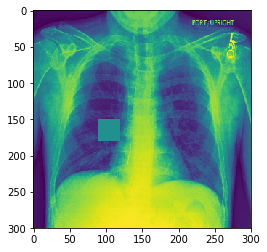

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0859, 0.0363, 0.0357, 0.0047, 0.0127]], device='cuda:0')


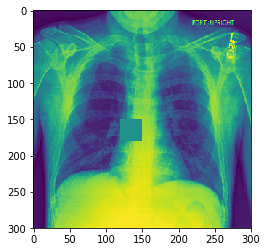

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0754, 0.0288, 0.0338, 0.0059, 0.0112]], device='cuda:0')


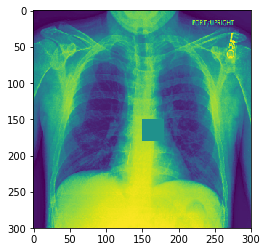

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0799, 0.0278, 0.0366, 0.0068, 0.0086]], device='cuda:0')


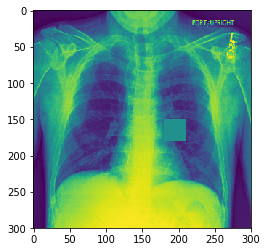

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0879, 0.0307, 0.0548, 0.0062, 0.0094]], device='cuda:0')


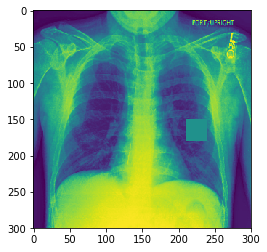

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0672, 0.0267, 0.0451, 0.0038, 0.0098]], device='cuda:0')


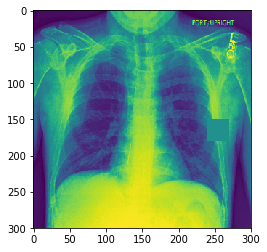

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0796, 0.0341, 0.0452, 0.0038, 0.0112]], device='cuda:0')


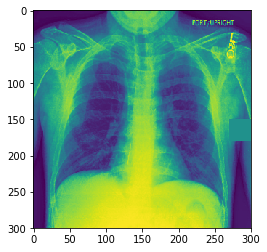

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0772, 0.0322, 0.0476, 0.0041, 0.0110]], device='cuda:0')


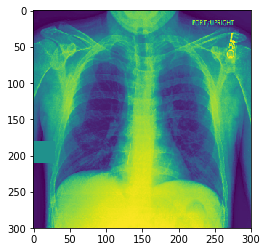

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0949, 0.0390, 0.0345, 0.0046, 0.0144]], device='cuda:0')


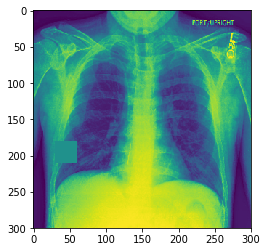

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.1607, 0.0408, 0.0236, 0.0054, 0.0176]], device='cuda:0')


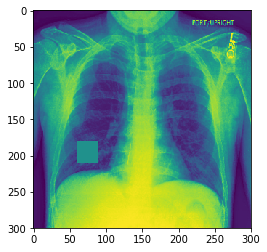

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.1106, 0.0382, 0.0254, 0.0058, 0.0173]], device='cuda:0')


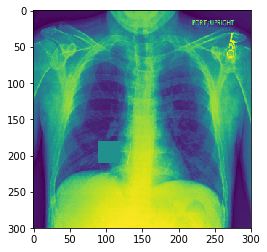

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0899, 0.0378, 0.0365, 0.0048, 0.0128]], device='cuda:0')


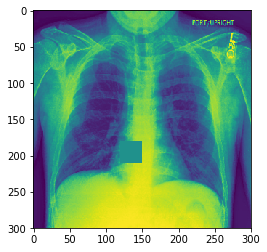

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0951, 0.0335, 0.0371, 0.0047, 0.0107]], device='cuda:0')


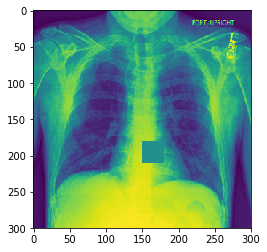

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0634, 0.0259, 0.0329, 0.0061, 0.0091]], device='cuda:0')


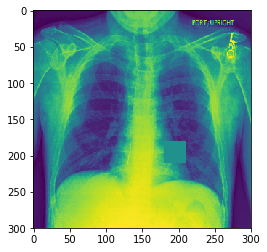

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0703, 0.0250, 0.0598, 0.0090, 0.0099]], device='cuda:0')


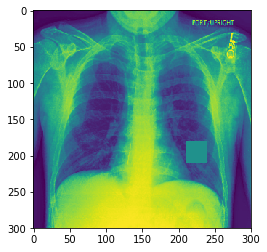

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0691, 0.0284, 0.0531, 0.0048, 0.0099]], device='cuda:0')


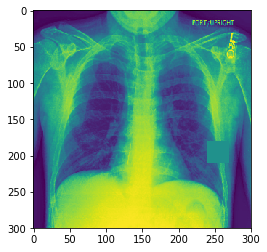

tensor([[0., 0., 0., 0., 0.]], device='cuda:0')
tensor([[0.0763, 0.0326, 0.0436, 0.0037, 0.0108]], device='cuda:0')


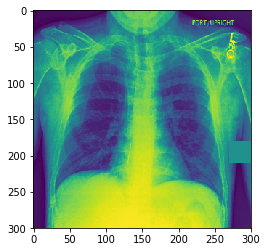

In [8]:
DATA_DIR = '/home/hanlin/231NProject/data'
TRAIN_IMAGE_LIST = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/train.csv'
VAL_IMAGE_LIST = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid.csv'
valid_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=VAL_IMAGE_LIST)

nnIsTrained = True
nnArchitecture = 'DENSE-NET-121'

nnClassCount = 9
classes = 5

trBatchSize = 1
trMaxEpoch = 50
transResize = (300, 300)
transCrop = 224
# input_index = 31
# target_index = 4

# input_index = 34
# class = 5
#1 -> first one
input_index = 10
target_index = 3

ChexnetTrainer.visualize(input_index, target_index,DATA_DIR,TRAIN_IMAGE_LIST,VAL_IMAGE_LIST,nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, transResize, transCrop,classes)


In [220]:
class ChexnetTrainer(): 
    def generate_gradients(input_index, target_class,loss,dataLoader,GBP):
        GBP.model.eval()        
        for batchID, (input, target) in enumerate (dataLoader):
            if batchID != input_index:
                continue;
                
            # Zero gradients
            GBP.model.zero_grad()
            target = target.cuda()
            varInput = torch.autograd.Variable(input, requires_grad=True)
            varTarget = torch.autograd.Variable(target)
            print(target)
            varOutput = GBP.model(varInput)


            varOutput[:,0] = torch.sigmoid(varOutput[:,0])
            varOutput[:,1] = torch.sigmoid(varOutput[:,1])
            varOutput[:,2] = torch.sigmoid(varOutput[:,2])
            
            
            bPRED = torch.zeros(varOutput.shape[0], 5).cuda()
            bPRED[:,0] = varOutput[:,0]
            bPRED[:,1] = varOutput[:,1]
            bPRED[:,2] = varOutput[:,2]

            softmax = torch.nn.Softmax()
            soft_a = softmax(varOutput[:,3:6]).data
            a0, a1, a2 = soft_a[:, 0], soft_a[:, 1], soft_a[:, 2]
            bPRED[:, 3] = a1/(a0+a1)
            soft_b = softmax(varOutput[:,6:9]).data
            b0, b1, b2 = soft_b[:, 0], soft_b[:, 1], soft_b[:, 2]
            bPRED[:, 4] = b1/(b0+b1)
            print(varTarget)
            print(bPRED)
            
            lossvalue = loss(varOutput,varTarget,target_class)
            print(lossvalue)
            lossvalue.backward()
#             varInput = occlude(varInput,0,0)
            gradients_as_arr = varInput.grad.abs().max(dim=1)[0].squeeze().cpu().numpy()
            return gradients_as_arr, varInput.squeeze().detach().cpu().numpy()
    
    def occlude_grads(input_index, target_class,loss,dataLoader,model):
        model.eval()        
        with torch.no_grad():
            for batchID, (input, target) in enumerate (dataLoader):
                if batchID != input_index:
                    continue;

                # Zero gradients
                model.zero_grad()
                target = target.cuda()
                varInput = torch.autograd.Variable(input, requires_grad=True)
                varTarget = torch.autograd.Variable(target)

                for i in range(90,210,30):
                    for j in range(0,300,30):
                        model.zero_grad()
                        varInputi = occlude(varInput.clone(),i,j)    
                        varOutput = model(varInputi)


                        varOutput[:,0] = torch.sigmoid(varOutput[:,0])
                        varOutput[:,1] = torch.sigmoid(varOutput[:,1])
                        varOutput[:,2] = torch.sigmoid(varOutput[:,2])


                        ### VAL Preds for AUROC
                        bPRED = torch.zeros(varOutput.shape[0], 5).cuda()
                        bPRED[:,0] = varOutput[:,0]
                        bPRED[:,1] = varOutput[:,1]
                        bPRED[:,2] = varOutput[:,2]

                        softmax = torch.nn.Softmax()
                        soft_a = softmax(varOutput[:,3:6]).data
                        a0, a1, a2 = soft_a[:, 0], soft_a[:, 1], soft_a[:, 2]
                        bPRED[:, 3] = a1/(a0+a1)
                        soft_b = softmax(varOutput[:,6:9]).data
                        b0, b1, b2 = soft_b[:, 0], soft_b[:, 1], soft_b[:, 2]
                        bPRED[:, 4] = b1/(b0+b1)
                        print(varTarget)
                        print(bPRED)
                        varInputi = varInputi.squeeze().detach().cpu().numpy()
                        plt.imshow(varInputi[0,:,:])
                        plt.show()
                        del softmax
                        del soft_a
                        del a0
                        del a1
                        del a2
                        del b1
                        del b2
                        del b0
                        del bPRED
                        del varOutput
                        del varInputi
    
    def visualize(input_index, target_index,pathDirData, pathFileTrain, pathFileVal, nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, transResize, transCrop,classes):
        
        def lossCriterion(varOutput,varTarget,spec_class):
            CEloss =  torch.nn.CrossEntropyLoss()
            BCEloss = torch.nn.BCELoss()

            L1 = BCEloss(varOutput[:,0],varTarget[:,0]) 
            L2 = BCEloss(varOutput[:,1],varTarget[:,1])
            L3 = BCEloss(varOutput[:,2],varTarget[:,2])
            varTarget = varTarget.long()
            L4 = CEloss(varOutput[:,3:6],varTarget[:,3])
            L5 = CEloss(varOutput[:,6:9],varTarget[:,4])

            loss = torch.zeros(5)
            loss[0] = L1
            loss[1] = L2
            loss[2] = L3
            loss[3] = L4
            loss[4] = L5
            return loss[spec_class-1]
        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE
        if nnArchitecture == 'DENSE-NET-121': model = DenseNet121(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'DENSE-NET-169': model = DenseNet169(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'DENSE-NET-201': model = DenseNet201(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'RES-NET-18': model = ResNet18(nnClassCount, nnIsTrained).cuda()
        
        model = torch.nn.DataParallel(model).cuda()
        modelCheckpoint = torch.load('/home/hanlin/231NProject/best_models/forward121/m-37050_0-Copy1.897.pth.tar')
        model.load_state_dict(modelCheckpoint['state_dict'])
        
        
        #-------------------- SETTINGS: DATA TRANSFORMS |TRAIN|
        normalize = transforms.Normalize([0.50616586, 0.50616586, 0.50616586], [0.2879059, 0.2879059, 0.2879059]) #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        transformList = []
        transformList.append(transforms.Resize(transResize))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)    
        transformSequence=transforms.Compose(transformList)

        #-------------------- SETTINGS: DATASET BUILDER |TRAIN|
                    
        datasetTrain = ChestXrayDataSet(data_dir=pathDirData,image_list_file=pathFileTrain, transform=transformSequence)              
        dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=4, pin_memory=True)
        
        #-------------------- SETTINGS: DATASET BUILDERS |VAL|
        datasetVal =   ChestXrayDataSet(data_dir=pathDirData, image_list_file=pathFileVal, transform=transformSequence)
        dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=trBatchSize, shuffle=False, num_workers=4, pin_memory=True)
        
        
        #-------------------- SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

        #-------------------- SETTINGS: LOSS
        loss = lossCriterion
        
        
        
        
        #---------- Visualize code
        GBP = GuidedBackprop(model)
        


        # Guided backprop
        
        # Get gradients
#         GBP.generate_gradients = ChexnetTrainer.generate_gradients
        guided_grads, x = ChexnetTrainer.generate_gradients(input_index, target_index,lossCriterion,dataLoaderVal,GBP)

        
        print('Reg')
        plt.imshow(guided_grads)
        plt.show()
        plt.imshow(x[0,:,:])
        plt.show()

        
        
        # Save colored gradients
#         save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
#         # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        print(grayscale_guided_grads.shape)
#         plt.imshow(grayscale_guided_grads)
#         plt.show()

#         # Save grayscale gradients
#         save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')

#         # Positive and negative saliency maps
        pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        print('Pos')
        plt.imshow(pos_sal)
        plt.show()
#         print('Neg')
#         plt.imshow(neg_sal)
#         plt.show()



#         save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
#         save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
        print('Guided backprop completed')
        

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64547/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64545/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64547/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64546/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64548/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64549/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/pati

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Reg


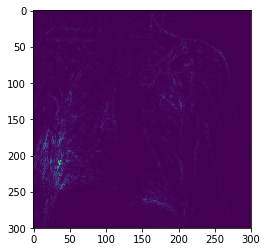

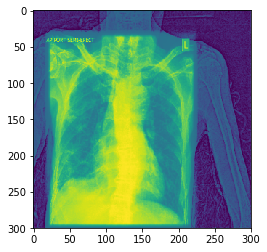

(1, 300)
Pos


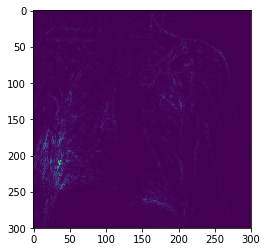

Guided backprop completed


In [221]:
DATA_DIR = '/home/hanlin/231NProject/data'
TRAIN_IMAGE_LIST = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/train.csv'
VAL_IMAGE_LIST = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid.csv'
valid_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=VAL_IMAGE_LIST)

nnIsTrained = True
nnArchitecture = 'DENSE-NET-121'

nnClassCount = 9
classes = 5

trBatchSize = 1
trMaxEpoch = 50
transResize = (300, 300)
transCrop = 224
# input_index = 31
# target_index = 4

# input_index = 34
# class = 5
#1 -> first one
#29
input_index = 2
target_index = 2

ChexnetTrainer.visualize(input_index, target_index,DATA_DIR,TRAIN_IMAGE_LIST,VAL_IMAGE_LIST,nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, transResize, transCrop,classes)


In [222]:
class ChexnetTrainer(): 
    def get_counts(input_index, target_class,loss,dataLoader,GBP):
        index2target = {}
        index2target['0'] = []
        index2target['1'] = []
        index2target['2'] = []
        index2target['3'] = []
        index2target['4'] = []
        counter = 0
        for batchID, (input, target) in enumerate (dataLoader):
            target = target.cpu().numpy()
            loop_counter = 0
            if target[0] == 1.0:
                loop_counter += 1
                index2target['0'].append(batchID)
            
            if target[1] == 1.0:
                loop_counter += 1
                index2target['1'].append(batchID)
            if target[2] == 1.0:
                loop_counter += 1
                index2target['2'].append(batchID)
            if target[3] == 1.0:
                loop_counter += 1
                index2target['3'].append(batchID)
            if target[4] == 1.0:
                loop_counter += 1
                index2target['4'].append(batchID)
            if loop_counter > 1:
                counter += 1
        print(counter)
        return index2target
            
    def visualize(input_index, target_index,pathDirData, pathFileTrain, pathFileVal, nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, transResize, transCrop,classes):
        
        def lossCriterion(varOutput,varTarget,spec_class):
            CEloss =  torch.nn.CrossEntropyLoss()
            BCEloss = torch.nn.BCELoss()

            L1 = BCEloss(varOutput[:,0],varTarget[:,0]) 
            L2 = BCEloss(varOutput[:,1],varTarget[:,1])
            L3 = BCEloss(varOutput[:,2],varTarget[:,2])
            varTarget = varTarget.long()
            L4 = CEloss(varOutput[:,3:6],varTarget[:,3])
            L5 = CEloss(varOutput[:,6:9],varTarget[:,4])

            loss = torch.zeros(5)
            loss[0] = L1
            loss[1] = L2
            loss[2] = L3
            loss[3] = L4
            loss[4] = L5
            return loss[spec_class-1]
        
        #-------------------- SETTINGS: NETWORK ARCHITECTURE
        if nnArchitecture == 'DENSE-NET-121': model = DenseNet121(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'DENSE-NET-169': model = DenseNet169(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'DENSE-NET-201': model = DenseNet201(nnClassCount, nnIsTrained).cuda()
        elif nnArchitecture == 'RES-NET-18': model = ResNet18(nnClassCount, nnIsTrained).cuda()
        
        model = torch.nn.DataParallel(model).cuda()
        modelCheckpoint = torch.load('/home/hanlin/231NProject/best_models/forward121/m-37050_0-Copy1.897.pth.tar')
        model.load_state_dict(modelCheckpoint['state_dict'])
        
        
        #-------------------- SETTINGS: DATA TRANSFORMS |TRAIN|
        normalize = transforms.Normalize([0.50616586, 0.50616586, 0.50616586], [0.2879059, 0.2879059, 0.2879059]) #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        transformList = []
        transformList.append(transforms.Resize(transResize))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)    
        transformSequence=transforms.Compose(transformList)

        #-------------------- SETTINGS: DATASET BUILDER |TRAIN|
                    
        datasetTrain = ChestXrayDataSet(data_dir=pathDirData,image_list_file=pathFileTrain, transform=transformSequence)              
        dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=4, pin_memory=True)
        
        #-------------------- SETTINGS: DATASET BUILDERS |VAL|
        datasetVal =   ChestXrayDataSet(data_dir=pathDirData, image_list_file=pathFileVal, transform=transformSequence)
        dataLoaderVal = DataLoader(dataset=datasetVal, batch_size=trBatchSize, shuffle=False, num_workers=4, pin_memory=True)
        
        
        #-------------------- SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

        #-------------------- SETTINGS: LOSS
        loss = lossCriterion
        
        
        
        
        #---------- Visualize code
        GBP = GuidedBackprop(model)
        
        index2target = ChexnetTrainer.get_counts(input_index, target_index,lossCriterion,datasetTrain,GBP)

        print(index2target)
 

In [212]:
DATA_DIR = '/home/hanlin/231NProject/data'
TRAIN_IMAGE_LIST = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/train.csv'
VAL_IMAGE_LIST = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid.csv'
valid_dataset = ChestXrayDataSet(data_dir=DATA_DIR,
                                image_list_file=VAL_IMAGE_LIST)

nnIsTrained = True
nnArchitecture = 'DENSE-NET-121'

nnClassCount = 9
classes = 5

trBatchSize = 1
trMaxEpoch = 50
transResize = (300, 300)
transCrop = 224
# input_index = 31
# target_index = 4

# input_index = 34
# class = 5
#1 -> first one
input_index = 23
target_index = 3

ChexnetTrainer.visualize(input_index, target_index,DATA_DIR,TRAIN_IMAGE_LIST,VAL_IMAGE_LIST,nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, transResize, transCrop,classes)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00005/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00005/study2/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00006/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00007/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00050/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00051/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00052/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00053/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00054/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00055/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00055/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00055/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00056/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00056/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00081/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00081/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00082/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00083/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00084/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00084/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00085/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00085/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00085/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00085/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00122/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00122/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00123/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00123/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00123/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00124/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00124/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00124/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00124/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00124/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study31/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study18/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study27/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00146/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00178/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00178/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00178/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00178/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00178/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00179/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00179/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00179/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00180/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00180/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00221/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00255/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00255/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00255/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00255/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00255/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00256/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00256/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00256/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00256/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00256/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00294/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00317/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00317/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00317/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00317/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00317/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00318/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00319/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00319/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00319/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00319/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00360/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00361/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00362/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00362/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00363/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00363/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00363/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00364/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00364/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00365/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00413/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00414/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00414/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00414/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00414/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00414/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00415/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00415/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00415/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00415/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00453/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00454/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00455/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00456/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00456/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00456/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00457/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00457/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00457/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00457/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00477/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00477/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00478/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00478/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00478/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00479/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00480/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00480/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00480/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00480/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00517/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00517/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00518/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00518/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00519/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00519/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00520/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00521/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00521/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00521/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00564/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00565/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00565/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00565/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00566/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00567/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00567/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00568/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00569/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00569/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00614/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00615/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00615/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00616/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00616/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00616/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00617/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00618/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00618/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00619/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00643/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00643/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00644/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00687/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00687/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00687/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00687/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00687/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00688/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00689/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00689/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00689/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00689/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00703/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00746/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00747/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00748/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00748/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00749/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00749/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00750/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00750/study35/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00750/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00750/study31/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00773/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00773/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00773/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00774/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00775/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00776/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00777/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00777/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00778/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00779/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00825/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00825/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study25/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00826/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00857/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00887/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study18/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study21/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00888/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00936/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00937/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00938/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient00972/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01015/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01015/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01016/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01016/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01017/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01017/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01018/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01018/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01018/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01018/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01065/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01066/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01100/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01101/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01137/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01137/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01137/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01137/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01137/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01138/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01139/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01140/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01141/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01141/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study34/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study49/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study45/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study46/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study24/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01167/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tra

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01201/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01202/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01202/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01202/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01202/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01202/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01203/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01204/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01204/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01205/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01239/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01240/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01241/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01242/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01280/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01280/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01281/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01282/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01282/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01283/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01283/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01283/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01283/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01283/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01333/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01334/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01335/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01335/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01335/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01335/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01335/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01335/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01336/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01337/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01375/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01375/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01376/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01376/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01376/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01376/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01376/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01376/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01377/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01378/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01423/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01423/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01423/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01423/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01424/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01425/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01425/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01426/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01426/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01426/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study24/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study53/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study40/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study34/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study41/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01457/study48/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/t

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01474/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01475/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01501/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01502/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01502/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01503/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01503/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01503/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01503/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01504/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01505/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01505/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01539/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01539/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01540/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01541/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01541/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01541/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01541/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01541/study3/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01542/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01543/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01566/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01566/study3/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01566/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01566/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01567/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01568/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01569/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01570/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01570/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01570/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01621/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01621/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01621/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01622/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01622/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01622/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01622/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01623/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01624/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01624/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study27/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01671/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/trai

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01705/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01705/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01705/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01706/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01707/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01708/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01708/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01709/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01709/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01709/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01767/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01767/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01768/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01768/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01768/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01769/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01770/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01770/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01770/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01770/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01802/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01803/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01803/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01830/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01830/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01831/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01832/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01852/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01853/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01854/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01854/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01854/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01855/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01856/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01856/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01856/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01857/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01902/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01902/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01903/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01932/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01932/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01932/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01933/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01934/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01935/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01935/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01936/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01936/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01936/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01984/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01984/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01985/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01986/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01987/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01987/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01988/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01988/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01989/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient01990/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02013/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/trai

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02057/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02057/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02057/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02058/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02059/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02059/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02059/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02059/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02059/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02059/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study43/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study38/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study35/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study25/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02080/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tra

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02119/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02120/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02121/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02121/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02121/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02122/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02122/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02122/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02122/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02122/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02155/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02155/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02155/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02156/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02156/study2/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02156/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02156/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02157/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02158/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02159/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02203/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02249/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02250/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02251/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02252/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02252/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02252/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02253/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02254/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02254/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02254/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02308/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02308/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02309/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02310/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02310/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02311/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02312/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02312/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02312/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02312/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02343/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02343/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02343/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02343/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02343/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02344/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02345/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02345/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02346/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02346/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02377/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02377/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02377/study18/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02378/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02406/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02406/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02406/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02406/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02407/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02407/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02407/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02408/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02408/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02408/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02451/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02451/study3/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02451/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02451/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02451/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02452/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02453/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02453/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02454/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02455/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02484/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02485/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02485/study2/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02485/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02486/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02487/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02488/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02489/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02490/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02491/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02531/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02532/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02532/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02532/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02569/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02569/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02569/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02570/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02571/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02571/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02572/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02573/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02574/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02574/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02622/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02622/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02622/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02622/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02623/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02624/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02624/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02624/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02624/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02624/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02662/study24/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/trai

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02693/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02694/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02727/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02728/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02762/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02762/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02762/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02762/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02762/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02762/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02763/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02764/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02764/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02764/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02787/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02788/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02789/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02790/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02790/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02790/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02790/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02791/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02791/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02792/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02847/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/trai

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02887/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02887/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02887/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02887/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02888/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02888/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02889/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02890/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02891/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02891/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02929/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02930/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02930/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02930/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02931/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02931/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02932/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02932/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02933/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02933/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02962/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02963/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient02963/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03006/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03006/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03006/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03006/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03006/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03006/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03007/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03007/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03007/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03007/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03048/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03048/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study5/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03049/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03078/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03078/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03079/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03080/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03081/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03082/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03082/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03082/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03082/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03083/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03115/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03116/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03117/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03118/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03119/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03119/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03119/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03120/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03120/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03120/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03134/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03135/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03136/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03136/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03137/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03138/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03138/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03138/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03138/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03138/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03181/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03181/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03182/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03183/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03184/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03185/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03186/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03186/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03186/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03186/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03235/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03235/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03235/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03235/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03235/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03236/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03236/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03237/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03238/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03238/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03282/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03283/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03322/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03323/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03323/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03323/study2/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03324/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03324/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03324/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03324/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03325/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03325/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03385/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03385/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03386/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03386/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03387/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03387/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03387/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03387/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03387/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03387/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03419/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03420/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03420/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03420/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03420/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03421/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03421/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03422/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03422/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03422/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03450/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03450/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03451/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study29/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study24/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03452/study30/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03478/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03479/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03480/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03480/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03517/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03542/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03542/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03542/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03543/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03544/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03544/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03544/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03544/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03544/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03544/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03571/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03618/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03619/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03655/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03688/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03689/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03689/study2/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03689/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03690/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03690/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03690/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03691/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03691/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03692/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03738/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03739/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03739/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03740/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03740/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03741/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03741/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03741/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03741/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03741/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03779/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03780/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study21/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03781/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03822/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03823/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03824/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03824/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03824/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03825/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03826/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03827/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03828/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03828/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03870/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03871/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03872/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03872/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03873/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03874/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03875/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03876/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03877/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03878/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03922/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03923/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03924/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03961/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03962/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03962/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03962/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03962/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03963/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03963/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03963/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03964/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient03965/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04027/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04027/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04027/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04027/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04027/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04027/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04028/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04028/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04029/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04030/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04050/study25/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04050/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04051/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04051/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04052/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04052/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04053/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04054/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04054/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04055/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study34/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study38/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study42/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study41/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04083/study29/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tra

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04100/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04100/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04101/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study11/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04102/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tra

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study27/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study28/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04135/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/t

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04171/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04172/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04217/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04217/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04217/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04218/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04219/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04219/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04220/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04221/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04222/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04223/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04257/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04257/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04258/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04259/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04259/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04259/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04259/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04259/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04260/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04260/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04304/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04339/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04340/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04341/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04342/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04342/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04343/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04344/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04344/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04344/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04344/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04378/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04379/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04380/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04381/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04382/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04383/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04383/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04383/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04384/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04384/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study24/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study31/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04427/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tr

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study30/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study46/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study79/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study28/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study59/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study51/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study82/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04462/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tr

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study21/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04468/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/trai

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04516/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04516/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04517/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04518/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04519/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04520/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04521/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04522/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04523/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04523/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04567/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04568/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04569/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04607/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04607/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04607/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04607/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04608/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04608/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04608/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04608/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04608/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04609/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04653/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04653/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04653/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04653/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04653/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04654/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04654/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04654/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04654/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04654/study18/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04674/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04674/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04675/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04675/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04675/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04675/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04676/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04677/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04677/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04678/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04714/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04715/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04715/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04715/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04716/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04716/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04717/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04717/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04717/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04717/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04738/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04739/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study25/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study21/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study28/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04774/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tra

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04817/study22/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/trai

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04851/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04852/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04852/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04852/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04852/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04853/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04854/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04854/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04854/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04855/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04896/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04916/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04916/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04916/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04916/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04917/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04917/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04918/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04918/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04918/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04918/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04943/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04944/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04945/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04978/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04978/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04978/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04978/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04979/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04980/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04981/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04981/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04981/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient04981/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05008/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05008/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05008/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05009/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05010/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05010/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05010/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05010/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05011/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05011/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05047/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05047/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05047/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05048/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05048/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05049/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05050/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05050/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05050/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05050/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study2/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study6/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05070/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study35/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study38/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study39/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study27/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study42/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study16/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study17/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05109/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/t

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05128/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05128/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05129/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05129/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05129/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05129/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05129/study4/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05130/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05130/study3/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05130/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05165/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05165/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05165/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05165/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05166/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05166/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05166/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05166/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05166/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05166/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study33/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study32/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study18/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05189/study27/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/t

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05225/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05225/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05225/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05225/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05226/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05226/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05226/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05227/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05228/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05229/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05245/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05245/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05246/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05247/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05248/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05248/study5/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05248/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05248/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05248/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05248/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05284/study3/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05284/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05285/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05328/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05328/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05329/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05330/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05375/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05376/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05377/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05378/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05379/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05379/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05380/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05381/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05381/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05381/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05406/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05407/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05407/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05443/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05443/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05444/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05445/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05446/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05447/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05448/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05449/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05450/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05451/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05488/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05488/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05488/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05489/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05490/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05491/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05492/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05493/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05494/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05495/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05533/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05534/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05581/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05581/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05581/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05582/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05582/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05582/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05582/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05583/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05583/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05583/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05626/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05626/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05626/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05626/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05627/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05627/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05627/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05628/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05628/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05628/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05668/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05669/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05669/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05670/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05670/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05670/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05671/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05672/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05672/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05673/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study66/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study42/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study28/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study48/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05702/study17/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tra

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study14/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study23/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study15/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study20/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study26/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05735/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/tr

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05771/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05771/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05772/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05772/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05772/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05773/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05773/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05773/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05773/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05773/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05812/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05813/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05813/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05814/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05814/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05814/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05815/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05815/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05816/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05817/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05852/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05852/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05852/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05852/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05853/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05853/study1/view2_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05854/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05854/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05855/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05856/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pat

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05886/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05887/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05888/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05889/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05890/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05890/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05890/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05891/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05891/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05891/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05927/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05928/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05929/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study9/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study13/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05930/study12/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/p

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05974/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05975/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05975/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05975/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05975/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05975/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05975/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05976/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05976/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient05976/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pati

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study5/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study6/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study4/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study7/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study8/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06022/study11/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06047/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06048/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06049/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06049/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06050/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06050/study3/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06050/study2/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06051/study10/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06051/study19/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/patient06051/study1/view1_frontal.jpg
/home/hanlin/231NProject/data/CheXpert-v1.0-small/train/pa

KeyboardInterrupt: 

In [110]:
class forward_side(nn.Module):
    def __init__(self, nnClassCount, forward_cp, side_cp):
        super(forward_side, self).__init__()
        self.forwardModel = DenseNet121(nnClassCount, False)
        self.sideModel = DenseNet121(nnClassCount, False)
        
#         Fstate_dict = self.change_state_dict_keys(torch.load(forward_cp, map_location='cpu')['state_dict'])
#         Cstate_dict = self.change_state_dict_keys(torch.load(side_cp, map_location='cpu')['state_dict'])
#         self.forwardModel.load_state_dict(Fstate_dict)
#         self.sideModel.load_state_dict(Cstate_dict)
        
        
        for param in self.forwardModel.parameters():
            param.requires_grad = False
        for param in self.sideModel.parameters():
            param.requires_grad = False
        
        self.FkernelCount = self.forwardModel.densenet121.classifier.in_features
        self.SkernelCount = self.sideModel.densenet121.classifier.in_features
        self.forwardModel.densenet121.classifier = nn.Identity()
        self.sideModel.densenet121.classifier = nn.Identity()
        
        self.fc1 = nn.Linear(self.FkernelCount+self.SkernelCount,500)
        self.fc2 = nn.Linear(500,100)
        self.fc3 = nn.Linear(100,nnClassCount)
        
    def change_state_dict_keys(self,state_dict):
        keys = state_dict.keys()
        new_state_dict = {}
        for key in keys:
            clean_k = '.'.join(key.split('.')[1:]) # module.dense121.conv0.weight -> dense121.conv0.weight
            new_state_dict[clean_k] = state_dict[key]
        return new_state_dict
        
    def forward(self, xF,xS):
        xF = self.forwardModel(xF)
        xS = self.sideModel(xS)
        x = torch.cat((xF,xS),-1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The venture down to nail our side model

In [111]:
#!/usr/bin/env python
# coding: utf-8
import torch
import os
import torchvision.transforms as transforms
import numpy as np
import time
import sys
import csv

import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import PIL
import torch.nn.functional as func

from torch.utils.data import Dataset
from models.chexnet.DensenetModels import DenseNet121, DenseNet169


class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, x):
        return x


def computeAUROC (dataGT, dataPRED, classCount):
    outAUROC = []

    datanpGT = dataGT.cpu().numpy()
    datanpPRED = dataPRED.cpu().numpy()

    for i in range(classCount):
        outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))

    return outAUROC


normalize = transforms.Normalize([0.50616586, 0.50616586, 0.50616586], [0.2879059, 0.2879059, 0.2879059]) 
        
transformList = []
transResize = (300, 300)
transformList.append(transforms.Resize(transResize))
transformList.append(transforms.ToTensor())
transformList.append(normalize)    
transform = transforms.Compose(transformList)

def load_and_resize_img(path):
    """
    Load and convert the full resolution images on CodaLab to
    low resolution used in the small dataset.
    """    
  #  img = cv2.imread(path, 0) 
    img = Image.open(path)
    size = img.size
    max_dim = max(size)
    max_ind = size.index(max_dim)
    
    if max_ind == 0:
        # width fixed at 320
        wpercent = (320 / float(size[0]))
        hsize = int((size[1] * wpercent))
        new_size = (hsize, 320)
        
    else:
        # height fixed at 320
        hpercent = (320 / float(size[1]))
        wsize = int((size[0] * hpercent))
        new_size = (320, wsize)

    resized_img = img.resize(new_size, PIL.Image.BILINEAR)#Image.fromarray(cv2.resize(img, new_size).astype('uint8'))

    return resized_img


def both_views(front_image_name, side_image_name):
    side_image = load_and_resize_img(side_image_name).convert('RGB')
    front_image =  load_and_resize_img(front_image_name).convert('RGB')
    
#    side_image = Image.fromarray(side_image_np.astype('uint8'), 'RGB') 
#    front_image = Image.fromarray(front_image_np.astype('uint8'), 'RGB') 
        
    if transform is not None:
        side_image = transform(side_image)
        front_image = transform(front_image)
    return front_image, side_image

def get_images(image_name):
    """
    Args:
        index: the index of item
    Returns:
        image
    """
    if 'frontal' in image_name:
        front_image_name = image_name
        side_image_name = image_name.replace('1_frontal', '2_lateral')
        if os.path.isfile(side_image_name):
            return both_views(front_image_name, side_image_name)

    if 'lateral' in image_name:
        side_image_name = image_name
        front_image_name = side_image_name.replace('2_lateral', '1_frontal')
        if os.path.isfile(front_image_name):
            return both_views(front_image_name, side_image_name)
        
 #   image_np = cv2.cvtColor(load_and_resize_img(image_name) , cv2.COLOR_GRAY2RGB) 
    image = load_and_resize_img(image_name).convert('RGB')
#    image = Image.fromarray(image_np.astype('uint8'), 'RGB') 
    if transform is not None:
        image = transform(image)
    return image, torch.ones((1,1,1))

def extract_study_path(path):
    paths = path.split('/')
    return '/'.join(paths[:-1])

In [231]:

def predict_front(front_image):
    model_zoo = front_model_zoo()
    for model in model_zoo:
        model.eval()
    varInput = torch.autograd.Variable(front_image)
    varInput = torch.unsqueeze(varInput, 0)
    predictions = []
    for model in model_zoo:
        probs = to_probs(model(varInput))
        predictions.append(probs.cpu().numpy().squeeze())
    
    predictions = np.array(predictions)
    del model_zoo
    
    return np.mean(predictions, axis=0)


def predict_hybrid(front_image, side_image):
    model_zoo = hybrid_model_zoo()
    for model in model_zoo:
        model.eval()
    varFrontInput = torch.autograd.Variable(front_image)
    varFrontInput = torch.unsqueeze(varFrontInput, 0)
    
    varSideInput = torch.autograd.Variable(side_image)
    varSideInput = torch.unsqueeze(varSideInput, 0)
    predictions = []
    for model in model_zoo:
        probs = to_probs(model(varFrontInput, varSideInput))
        predictions.append(probs.cpu().numpy().squeeze())
    
    predictions = np.array(predictions)
    return np.mean(predictions, axis=0)    

def visualize_hybrid(front_image, side_image,target,target_class):
    def lossCriterion(varOutput,varTarget,spec_class):
        CEloss =  torch.nn.CrossEntropyLoss()
        BCEloss = torch.nn.BCELoss()

        L1 = BCEloss(varOutput[:,0],varTarget[:,0]) 
        L2 = BCEloss(varOutput[:,1],varTarget[:,1])
        L3 = BCEloss(varOutput[:,2],varTarget[:,2])
        varTarget = varTarget.long()
        L4 = CEloss(varOutput[:,3:6],varTarget[:,3])
        L5 = CEloss(varOutput[:,6:9],varTarget[:,4])

        loss = torch.zeros(5)
        loss[0] = L1
        loss[1] = L2
        loss[2] = L3
        loss[3] = L4
        loss[4] = L5
        return loss[spec_class-1]
    dud = '/home/hanlin/231NProject/hybrid_codalab/src/model_weights/m-37050_0-Copy1.897.pth.tar'
    model = forward_side(9, dud, dud)
    model = torch.nn.DataParallel(model).cuda()
    modelCheckpoint = torch.load('/home/hanlin/231NProject/hybrid_codalab/src/model_weights/hybrid_zoo/m-1750_0-Copy1.956.pth.tar')
    model.load_state_dict(modelCheckpoint['state_dict'])
    model.eval()
    GBP = GuidedBackprop(model)

    GBP.model.zero_grad()
    target = torch.tensor(target).cuda()
    varFrontInput = torch.autograd.Variable(front_image.unsqueeze(0), requires_grad=True) 
    varSideInput = torch.autograd.Variable(side_image.unsqueeze(0), requires_grad=True)

    print(target)
    varTarget = torch.autograd.Variable(target.unsqueeze(0)).float()

    varOutput = GBP.model(varFrontInput,varSideInput)

#     print(varOutput.shape)
    varOutput[:,0] = torch.sigmoid(varOutput[:,0])
    varOutput[:,1] = torch.sigmoid(varOutput[:,1])
    varOutput[:,2] = torch.sigmoid(varOutput[:,2])

    
    
    lossvalue = lossCriterion(varOutput,varTarget,target_class)
    ### VAL Preds for AUROC
    bPRED = torch.zeros(varOutput.shape[0], 5).cuda()
    bPRED[:,0] = varOutput[:,0]
    bPRED[:,1] = varOutput[:,1]
    bPRED[:,2] = varOutput[:,2]

    softmax = torch.nn.Softmax()
    soft_a = softmax(varOutput[:,3:6]).data
    a0, a1, a2 = soft_a[:, 0], soft_a[:, 1], soft_a[:, 2]
    bPRED[:, 3] = a1/(a0+a1)
    soft_b = softmax(varOutput[:,6:9]).data
    b0, b1, b2 = soft_b[:, 0], soft_b[:, 1], soft_b[:, 2]
    bPRED[:, 4] = b1/(b0+b1)
    print(varTarget)
    print(bPRED)

    
#     lossvalue = torch.autograd.Variable(lossvalue, requires_grad = True)
    lossvalue.backward()

    gradients_as_arr = varSideInput.grad.abs().max(dim=1)[0].squeeze().cpu().numpy()
    fr_grads = varFrontInput.grad.abs().max(dim=1)[0].squeeze().cpu().numpy()
    
    x = varSideInput.squeeze().detach().cpu().numpy()
    x2 = varFrontInput.squeeze().detach().cpu().numpy()
    plt.imshow(gradients_as_arr)
    plt.show()
    plt.imshow(fr_grads)
    plt.show()
    plt.imshow(x[0,:,:])
    plt.show()
    plt.imshow(x2[0,:,:])
    plt.show()
    
    
    



def predict(im_name,label,target_class):
    (front_image, side_image) = get_images(im_name)
    c, h, w = side_image.shape

    if w == 1 and c == 1 and h == 1:
        # only front
        print('Hi')
        return False
    else:
        print('Hi2')
        visualize_hybrid(front_image, side_image,label,target_class)
        return True
#         return predict_hybrid(front_image, side_image)
    
#         return predict_front(front_image)

def vis_side(target_class,infile='valid_image_paths.csv'):
    def convert_to_ones(df, disease):
        df[disease] = df[disease].replace([-1.0], 1.0)
    
    def convert_to_zeros(df, disease):
        df[disease] = df[disease].replace([-1.0], 0.0)
        
    def convert_to_multi(df, disease):
        df[disease] = df[disease].replace([-1.0], 2.0)
        
    chex_df = pd.read_csv(infile)
    chex_df = chex_df.fillna(0.0)
    
    diseases=['Atelectasis', 'Consolidation', 'Edema','Cardiomegaly', 'Pleural Effusion']
#     chex_df = chex_df.loc[chex_df['Frontal/Lateral'] == side]
    convert_to_ones(chex_df, 'Atelectasis')
    convert_to_ones(chex_df, 'Consolidation')
    convert_to_ones(chex_df, 'Edema')
    convert_to_multi(chex_df, 'Cardiomegaly')
    convert_to_multi(chex_df, 'Pleural Effusion')

    labels = chex_df.as_matrix(columns=diseases)
    labels = list(labels)
#     print(labels[:50])

    image_names = chex_df.as_matrix(columns=['Path']).flatten()
#     image_names = [os.path.join(data_dir, im_name) for im_name in image_names]

#     list_of_seen = [1,2,8,9,13,14,19,20,22,23,24]
    
    for index,im_name in enumerate(image_names):
        print(im_name)
        print(index)
        label = labels[index]
        print(label)
#         if index in list_of_seen:
#             continue

        
        im_name = '/home/hanlin/231NProject/data/' + im_name 
        im_name = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64550/study1/view1_frontal.jpg'
        if predict(im_name,label,target_class):
           break; 

def get_labels_dict(infile='valid_image_paths.csv'):
    study_path_to_labels = {}
    with torch.no_grad():
        with open (infile, 'r') as f:
            chex_df = csv.reader(f)
            next(chex_df, None)
            list_image_names = []
            
            for row in chex_df:
                list_image_names.append(row[0])
#        chex_df = pd.read_csv(infile)
#        list_image_names = list(chex_df['Path'])
        study_path_set = []
        for im_name in list_image_names:
            print(im_name)
            im_name = '/home/hanlin/231NProject/data/' + im_name 
            im_name = '/home/hanlin/231NProject/data/CheXpert-v1.0-small/valid/patient64550/study1/view1_frontal.jpg'
            study_path = extract_study_path(im_name)
            if study_path in study_path_set:
                continue
            study_path_set.append(study_path)
            labels = predict(im_name)
            study_path_to_labels[study_path] = labels
            return
    return study_path_to_labels

In [232]:
labels_dict = vis_side(1,VAL_IMAGE_LIST)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:161: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg
0
[0. 0. 0. 1. 0.]
Hi
CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg
1
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg
2
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg
3
[0. 0. 1. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg
4
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64545/study1/view1_frontal.jpg
5
[1. 0. 0. 0. 1.]
Hi
CheXpert-v1.0-small/valid/patient64546/study1/view1_frontal.jpg
6
[1. 0. 0. 1. 0.]
Hi
CheXpert-v1.0-small/valid/patient64547/study1/view1_frontal.jpg
7
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64547/study1/view2_frontal.jpg
8
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64547/study1/view3_lateral.jpg
9
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64548/study1/view1_frontal.jpg
10
[1. 1. 0. 1. 1.]
Hi
CheXpert-v1.0-small/valid/patient64549/study1/view1_f

Hi
CheXpert-v1.0-small/valid/patient64615/study1/view1_frontal.jpg
100
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64615/study1/view2_lateral.jpg
101
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64616/study1/view1_frontal.jpg
102
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64616/study1/view2_lateral.jpg
103
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64616/study1/view3_lateral.jpg
104
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64617/study1/view1_frontal.jpg
105
[0. 0. 0. 1. 0.]
Hi
CheXpert-v1.0-small/valid/patient64618/study1/view1_frontal.jpg
106
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64618/study1/view2_lateral.jpg
107
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64619/study1/view1_frontal.jpg
108
[1. 0. 0. 0. 1.]
Hi
CheXpert-v1.0-small/valid/patient64620/study1/view1_frontal.jpg
109
[1. 0. 0. 0. 1.]
Hi
CheXpert-v1.0-small/valid/patient64621/study1/view1_frontal.jpg
110
[0. 0. 0. 1. 0.]
Hi
CheXpert-v1.0-small/valid/pat

Hi
CheXpert-v1.0-small/valid/patient64705/study1/view2_lateral.jpg
198
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64706/study1/view1_frontal.jpg
199
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64707/study1/view1_frontal.jpg
200
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64708/study1/view1_frontal.jpg
201
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64709/study1/view1_frontal.jpg
202
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64710/study1/view1_frontal.jpg
203
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64711/study1/view1_frontal.jpg
204
[0. 0. 0. 1. 1.]
Hi
CheXpert-v1.0-small/valid/patient64712/study1/view1_frontal.jpg
205
[0. 0. 1. 1. 0.]
Hi
CheXpert-v1.0-small/valid/patient64713/study1/view1_frontal.jpg
206
[0. 0. 0. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64714/study1/view1_frontal.jpg
207
[1. 0. 1. 0. 0.]
Hi
CheXpert-v1.0-small/valid/patient64715/study1/view1_frontal.jpg
208
[1. 1. 1. 0. 1.]
Hi
CheXpert-v1.0-small/valid/pat

In [ ]:
"module.forwardModel.densenet121.features.conv0.weight"